In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [2]:
import os
os.environ['NLTK_DATA'] = 'D:/nltk_data'

In [ ]:
 !pip install pandas numpy scikit-learn nltk


In [4]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, precision_score


## Download NLTK resources

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


## Load datasetLoad dataset

In [6]:
df = pd.read_csv(r"D:\DS\data.csv")  
print("Data loaded successfully!")
df.head()


Data loaded successfully!


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


In [8]:
import nltk
nltk.data.path.append(r"C:\Users\ADMIN\AppData\Roaming\nltk_data")


In [ ]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')   
nltk.download('stopwords')
nltk.download('wordnet')

nltk.data.path.append(r"C:\Users\ADMIN\AppData\Roaming\nltk_data")


Preprocessing

In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))  # keep only letters
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

df['Sentence'] = df['Sentence'].fillna('')
df['cleaned_content'] = df['Sentence'].apply(preprocess_text)
df[['Sentence', 'cleaned_content']].head()


,Sentence,cleaned_content
0,The GeoSolutions technology will leverage Bene...,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",esi low real possibility
2,"For the last quarter of 2010 , Componenta 's n...",last quarter componenta net sale doubled eurm ...
3,According to the Finnish-Russian Chamber of Co...,according finnishrussian chamber commerce majo...
4,The Swedish buyout firm has sold its remaining...,swedish buyout firm sold remaining percent sta...


## labels


In [11]:
sentiment_mapping = {'positive': 1, 'negative': 0, 'neutral': 2}
df['sentiment_code'] = df['Sentiment'].map(sentiment_mapping)
df.dropna(subset=['sentiment_code'], inplace=True)
df['sentiment_code'] = df['sentiment_code'].astype(int)

X, y = df['cleaned_content'], df['sentiment_code']


## Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Data split complete!")


Data split complete!


## Pipeline with Word + Char TF-IDF

In [13]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('word_tfidf', TfidfVectorizer(
            analyzer='word',
            ngram_range=(1,2),
            max_df=0.9,
            min_df=5,
            sublinear_tf=True
        )),
        ('char_tfidf', TfidfVectorizer(
            analyzer='char',
            ngram_range=(3,5),
            min_df=3,
            sublinear_tf=True
        ))
    ])),
    ('clf', LinearSVC(class_weight='balanced', max_iter=5000))
])


## Hyperparameter tuning (precision focus)

In [14]:
param_grid = {
    'features__word_tfidf__ngram_range': [(1,1), (1,2)],
    'features__char_tfidf__ngram_range': [(3,5), (4,6)],
    'clf__C': [0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='precision_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)


Fitting 10 folds for each of 12 candidates, totalling 120 fits


,estimator,Pipeline(step..._iter=5000))])
,param_grid,"{'clf__C': [0.1, 1, ...], 'features__char_tfidf__ngram_range': [(3, ...), (4, ...)], 'features__word_tfidf__ngram_range': [(1, ...), (1, ...)]}"
,scoring,'precision_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformer_list,"[('word_tfidf', ...), ('char_tfidf', ...)]"


## Evaluation - Best Model

In [15]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nBest Parameters:", grid.best_params_)
print("\nClassification Report (Macro Precision Focus):")
print(classification_report(y_test, y_pred, target_names=['negative', 'positive', 'neutral'], digits=4))

precision = precision_score(y_test, y_pred, average='macro')
print(f"Macro Precision on Test Set: {precision:.4f}")



Best Parameters: {'clf__C': 0.1, 'features__char_tfidf__ngram_range': (3, 5), 'features__word_tfidf__ngram_range': (1, 2)}

Classification Report (Macro Precision Focus):
              precision    recall  f1-score   support

    negative     0.3611    0.3779    0.3693       172
    positive     0.7837    0.6739    0.7246       371
     neutral     0.7522    0.8051    0.7778       626

    accuracy                         0.7006      1169
   macro avg     0.6323    0.6190    0.6239      1169
weighted avg     0.7047    0.7006    0.7008      1169

Macro Precision on Test Set: 0.6323


## Logistic Regression Baseline

In [16]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

log_reg = LogisticRegression(max_iter=3000, class_weight='balanced', solver='liblinear')
log_reg.fit(X_train_tfidf, y_train)
y_pred_lg = log_reg.predict(X_test_tfidf)

precision_lg = precision_score(y_test, y_pred_lg, average='macro')
print(f"Macro Precision (Logistic Regression): {precision_lg:.4f}")
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lg, target_names=['negative', 'positive', 'neutral'], digits=4))

if precision > precision_lg:
    print("\n LinearSVC (precision-optimized) performed better.")
else:
    print("\n Logistic Regression performed better or similar.")


Macro Precision (Logistic Regression): 0.6229

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

    negative     0.3812    0.3547    0.3675       172
    positive     0.7476    0.6307    0.6842       371
     neutral     0.7399    0.8227    0.7791       626

    accuracy                         0.6929      1169
   macro avg     0.6229    0.6027    0.6103      1169
weighted avg     0.6896    0.6929    0.6884      1169


 LinearSVC (precision-optimized) performed better.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [17]:
def extract_features(text):
    words = text.split()
    sentences = nltk.sent_tokenize(text)
    
    word_count = len(words)
    char_count = len(text)
    avg_word_length = np.mean([len(w) for w in words]) if word_count > 0 else 0
    unique_word_count = len(set(words))
    unique_word_ratio = unique_word_count / word_count if word_count > 0 else 0
    sentence_count = len(sentences) if len(sentences) > 0 else 1
    avg_sentence_length = word_count / sentence_count
    punctuation_count = sum(1 for ch in text if ch in string.punctuation)
    digit_count = sum(c.isdigit() for c in text)
    uppercase_word_count = sum(1 for w in words if w.isupper())
    
    return pd.Series([
        word_count, char_count, avg_word_length, unique_word_count, 
        unique_word_ratio, sentence_count, avg_sentence_length, 
        punctuation_count, digit_count, uppercase_word_count
    ])


In [ ]:
df_features = pd.DataFrame({
    "text_length": df["Sentence"].astype(str).apply(len),
    "word_count": df["Sentence"].astype(str).apply(lambda x: len(x.split()))
})

df = pd.concat([df, df_features], axis=1)
print(df.head())


                                            Sentence Sentiment  \
0  The GeoSolutions technology will leverage Bene...  positive   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative   
2  For the last quarter of 2010 , Componenta 's n...  positive   
3  According to the Finnish-Russian Chamber of Co...   neutral   
4  The Swedish buyout firm has sold its remaining...   neutral   

                                     cleaned_content  sentiment_code  \
0  geosolutions technology leverage benefon gps s...               1   
1                           esi low real possibility               0   
2  last quarter componenta net sale doubled eurm ...               1   
3  according finnishrussian chamber commerce majo...               2   
4  swedish buyout firm sold remaining percent sta...               2   

   text_length  word_count  
0          218          32  
1           55          11  
2          193          39  
3          128          20  
4          135          2

In [19]:
df = pd.concat([df, df_features], axis=1)
print(df.head())


                                            Sentence Sentiment  \
0  The GeoSolutions technology will leverage Bene...  positive   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative   
2  For the last quarter of 2010 , Componenta 's n...  positive   
3  According to the Finnish-Russian Chamber of Co...   neutral   
4  The Swedish buyout firm has sold its remaining...   neutral   

                                     cleaned_content  sentiment_code  \
0  geosolutions technology leverage benefon gps s...               1   
1                           esi low real possibility               0   
2  last quarter componenta net sale doubled eurm ...               1   
3  according finnishrussian chamber commerce majo...               2   
4  swedish buyout firm sold remaining percent sta...               2   

   text_length  word_count  text_length  word_count  
0          218          32          218          32  
1           55          11           55          11  
2       

In [20]:
print(df.columns[df.columns.duplicated()].tolist())
df = df.loc[:, ~df.columns.duplicated()]



['text_length', 'word_count']


In [ ]:
df["char_count"] = df["Sentence"].astype(str).apply(len)

df["word_count"] = df["Sentence"].astype(str).apply(lambda x: len(x.split()))

df["avg_word_length"] = df["char_count"] / df["word_count"]
df["avg_word_length"] = df["avg_word_length"].replace([np.inf, -np.inf], 0).fillna(0)


In [22]:
import numpy as np
import re

df["char_count"] = df["Sentence"].astype(str).apply(len)
df["word_count"] = df["Sentence"].astype(str).apply(lambda x: len(x.split()))

df["avg_word_length"] = df["char_count"] / df["word_count"]
df["avg_word_length"] = df["avg_word_length"].replace([np.inf, -np.inf], 0).fillna(0)

df["unique_word_count"] = df["Sentence"].astype(str).apply(lambda x: len(set(x.split())))
df["unique_word_ratio"] = df["unique_word_count"] / df["word_count"]
df["unique_word_ratio"] = df["unique_word_ratio"].replace([np.inf, -np.inf], 0).fillna(0)

df["sentence_count"] = df["Sentence"].astype(str).apply(
    lambda x: len([s for s in re.split(r"[.!?]", x) if s.strip()])
)
df["avg_sentence_length"] = df["word_count"] / df["sentence_count"]
df["avg_sentence_length"] = df["avg_sentence_length"].replace([np.inf, -np.inf], 0).fillna(0)

df["punctuation_count"] = df["Sentence"].astype(str).apply(lambda x: sum(1 for ch in x if ch in ".,!?;:"))
df["digit_count"] = df["Sentence"].astype(str).apply(lambda x: sum(ch.isdigit() for ch in x))
df["uppercase_word_count"] = df["Sentence"].astype(str).apply(lambda x: sum(1 for w in x.split() if w.isupper()))


## Data Visualition

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

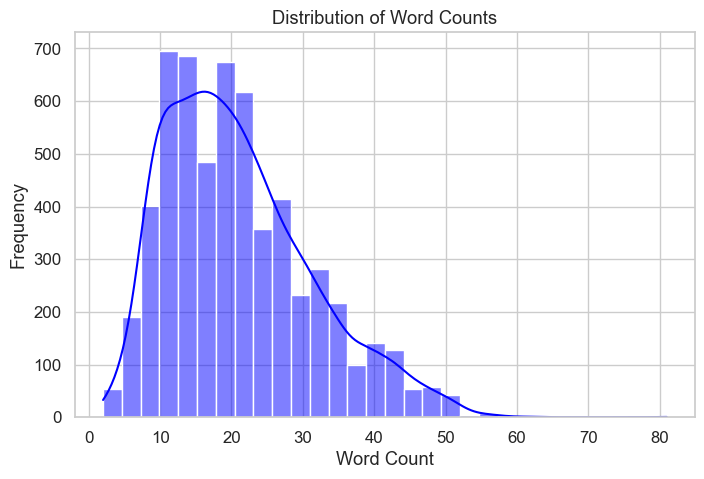

In [24]:
plt.figure(figsize=(8, 5))
sns.histplot(df["word_count"], bins=30, kde=True, color="blue")
plt.title("Distribution of Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

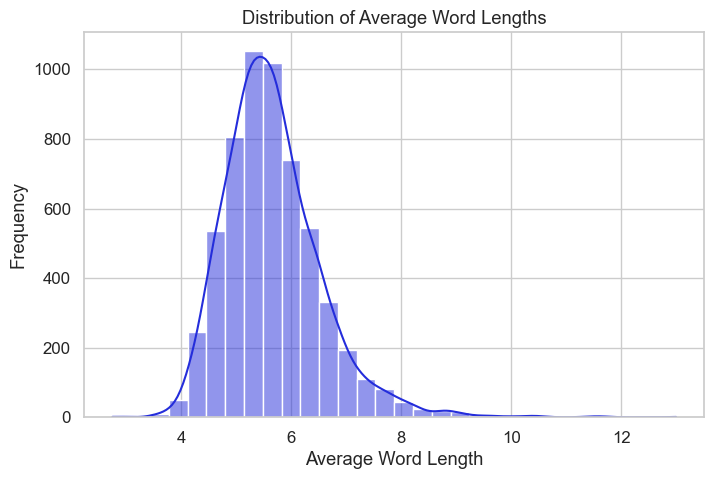

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(df["avg_word_length"], bins=30, kde=True, color="#242DDB")
plt.title("Distribution of Average Word Lengths")
plt.xlabel("Average Word Length")
plt.ylabel("Frequency")
plt.show()

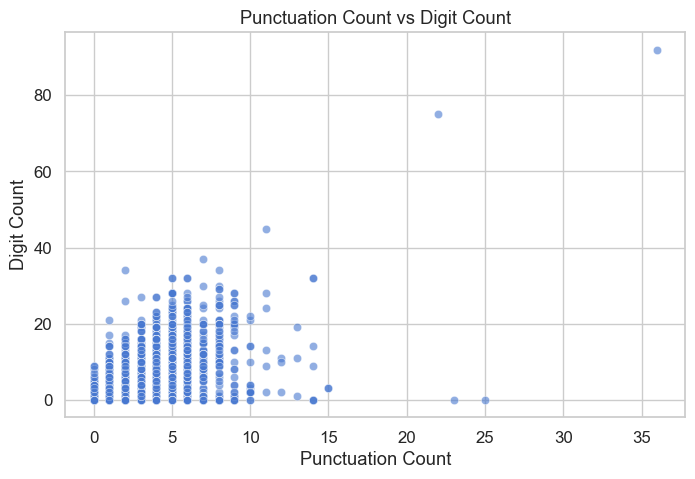

In [26]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["punctuation_count"], y=df["digit_count"], alpha=0.6)
plt.title("Punctuation Count vs Digit Count")
plt.xlabel("Punctuation Count")
plt.ylabel("Digit Count")
plt.show()

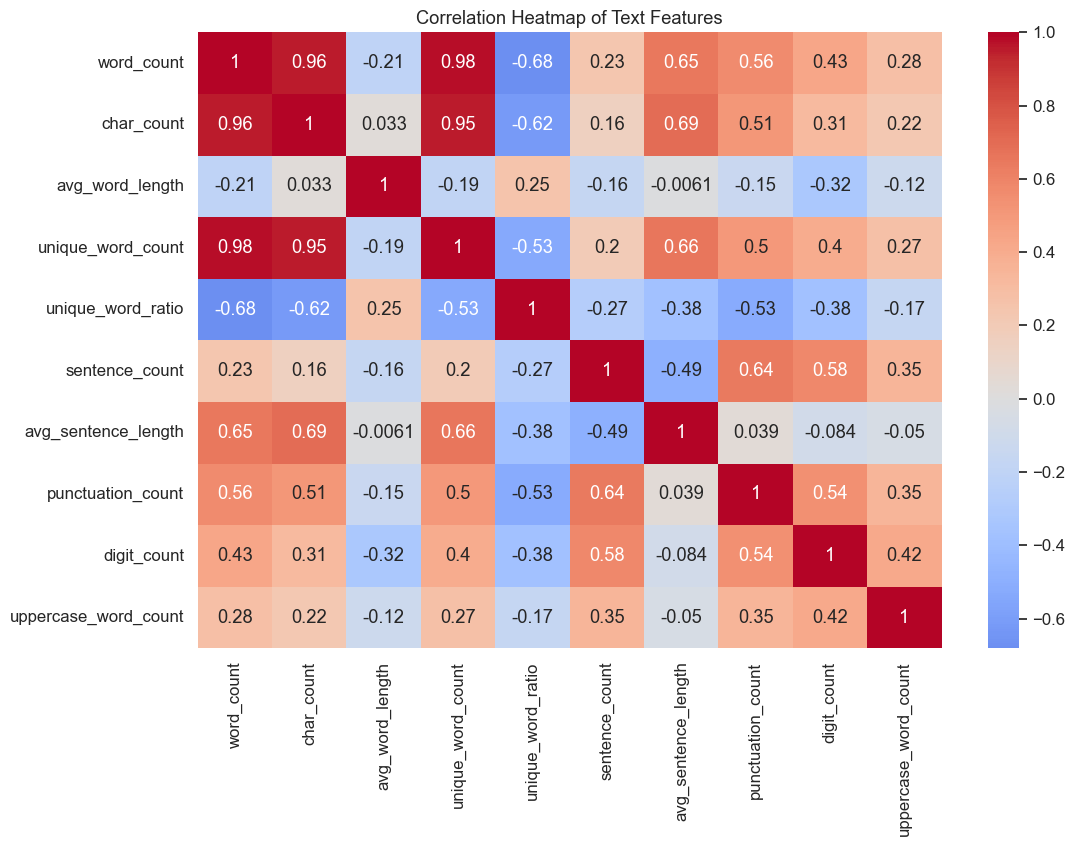

In [27]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    df[["word_count", "char_count", "avg_word_length", "unique_word_count",
        "unique_word_ratio", "sentence_count", "avg_sentence_length",
        "punctuation_count", "digit_count", "uppercase_word_count"]].corr(),
    annot=True, cmap="coolwarm", center=0
)
plt.title("Correlation Heatmap of Text Features")
plt.show()